# Train example of Ship segmentation U-net

## import libraries and modules

In [1]:
import random
import os
import tensorflow as tf
from tensorflow import keras
import pandas as pd
# set the random seed:
from utils.Constants import Constants
from utils.Utils import Utils
from models.Metrics.metrics import Metric
import cv2
from data import PrepData
import numpy as np
import keras.backend as K
import tensorflow_addons as tfa
from models.U_net_model import UNetModel
from models.Metrics.metrics import Metric
from models.Metrics.Loss.IoU import IoU as IoU_nodule
random.seed(Constants.RANDOM_SEED)

TRAIN_DIR = 'data/airbus-ship-detection/train_v2/'
TEST_DIR = 'data/airbus-ship-detection/test_v2/'

## Read Data

In [2]:
df = pd.read_csv("data/airbus-ship-detection/train_ship_segmentations_v2.csv")
df['EncodedPixels'] = df['EncodedPixels'].astype('string')

# Delete corrupted images
df = df.drop(df[df['ImageId'].isin(Constants.CORRUPTED_IMAGES)].index)

# Dataframe that contains the segmentation for each ship in the image.
instance_segmentation = df

# Dataframe that contains the segmentation of all ships in the image.
image_segmentation = df.groupby(by=['ImageId'])['EncodedPixels'].apply(lambda x: np.nan if pd.isna(x).any() else ' '.join(x)).reset_index()

### Prepare Data

In [4]:

# reduce the number of images without ships
images_without_ships = image_segmentation[image_segmentation['EncodedPixels'].isna()]['ImageId'].values[:Constants.IMAGES_WITHOUT_SHIPS_NUMBER]
images_with_ships = image_segmentation[image_segmentation['EncodedPixels'].notna()]['ImageId'].values
images_list = np.append(images_without_ships, images_with_ships)

# remove corrupted images
images_list = np.array(list(filter(lambda x: x not in Constants.CORRUPTED_IMAGES, images_list)))

### Prepare Dataset

In [ ]:
# Create a dataset of image file paths using TensorFlow's list_files() method
images_list = tf.data.Dataset.list_files([f'{TRAIN_DIR}{name}' for name in images_list], shuffle=True)
# Create a data preprocessor instance and pass in the image file path dataset and image segmentation parameter

data_preprocesor = PrepData.PrepData(images_list,image_segmentation)

# Get separate datasets for testing, validation, and training
test_dataset = data_preprocesor.get_test_dataset()
validation_dataset = data_preprocesor.get_validation_dataset()
train_dataset = data_preprocesor.get_train_dataset()

# Create batches of data for training, validation, and testing
train_batches = (
    train_dataset
    .repeat()
    .batch(Constants.BATCH_SIZE))# Repeat the training dataset and batch it by the specified batch size

validation_batches = validation_dataset.batch(Constants.BATCH_SIZE)# Batch the validation dataset by the specified batch size

test_batches = test_dataset.batch(Constants.BATCH_SIZE)# Batch the testing dataset by the specified batch size

TypeError: 'BatchDataset' object is not subscriptable

## Create and Train Model

Encoder output tensors: [<KerasTensor: shape=(None, 256, 256, 16) dtype=float32 (created by layer 'encoder')>, <KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'encoder')>, <KerasTensor: shape=(None, 64, 64, 64) dtype=float32 (created by layer 'encoder')>, <KerasTensor: shape=(None, 32, 32, 128) dtype=float32 (created by layer 'encoder')>]
Trainable params: 302896


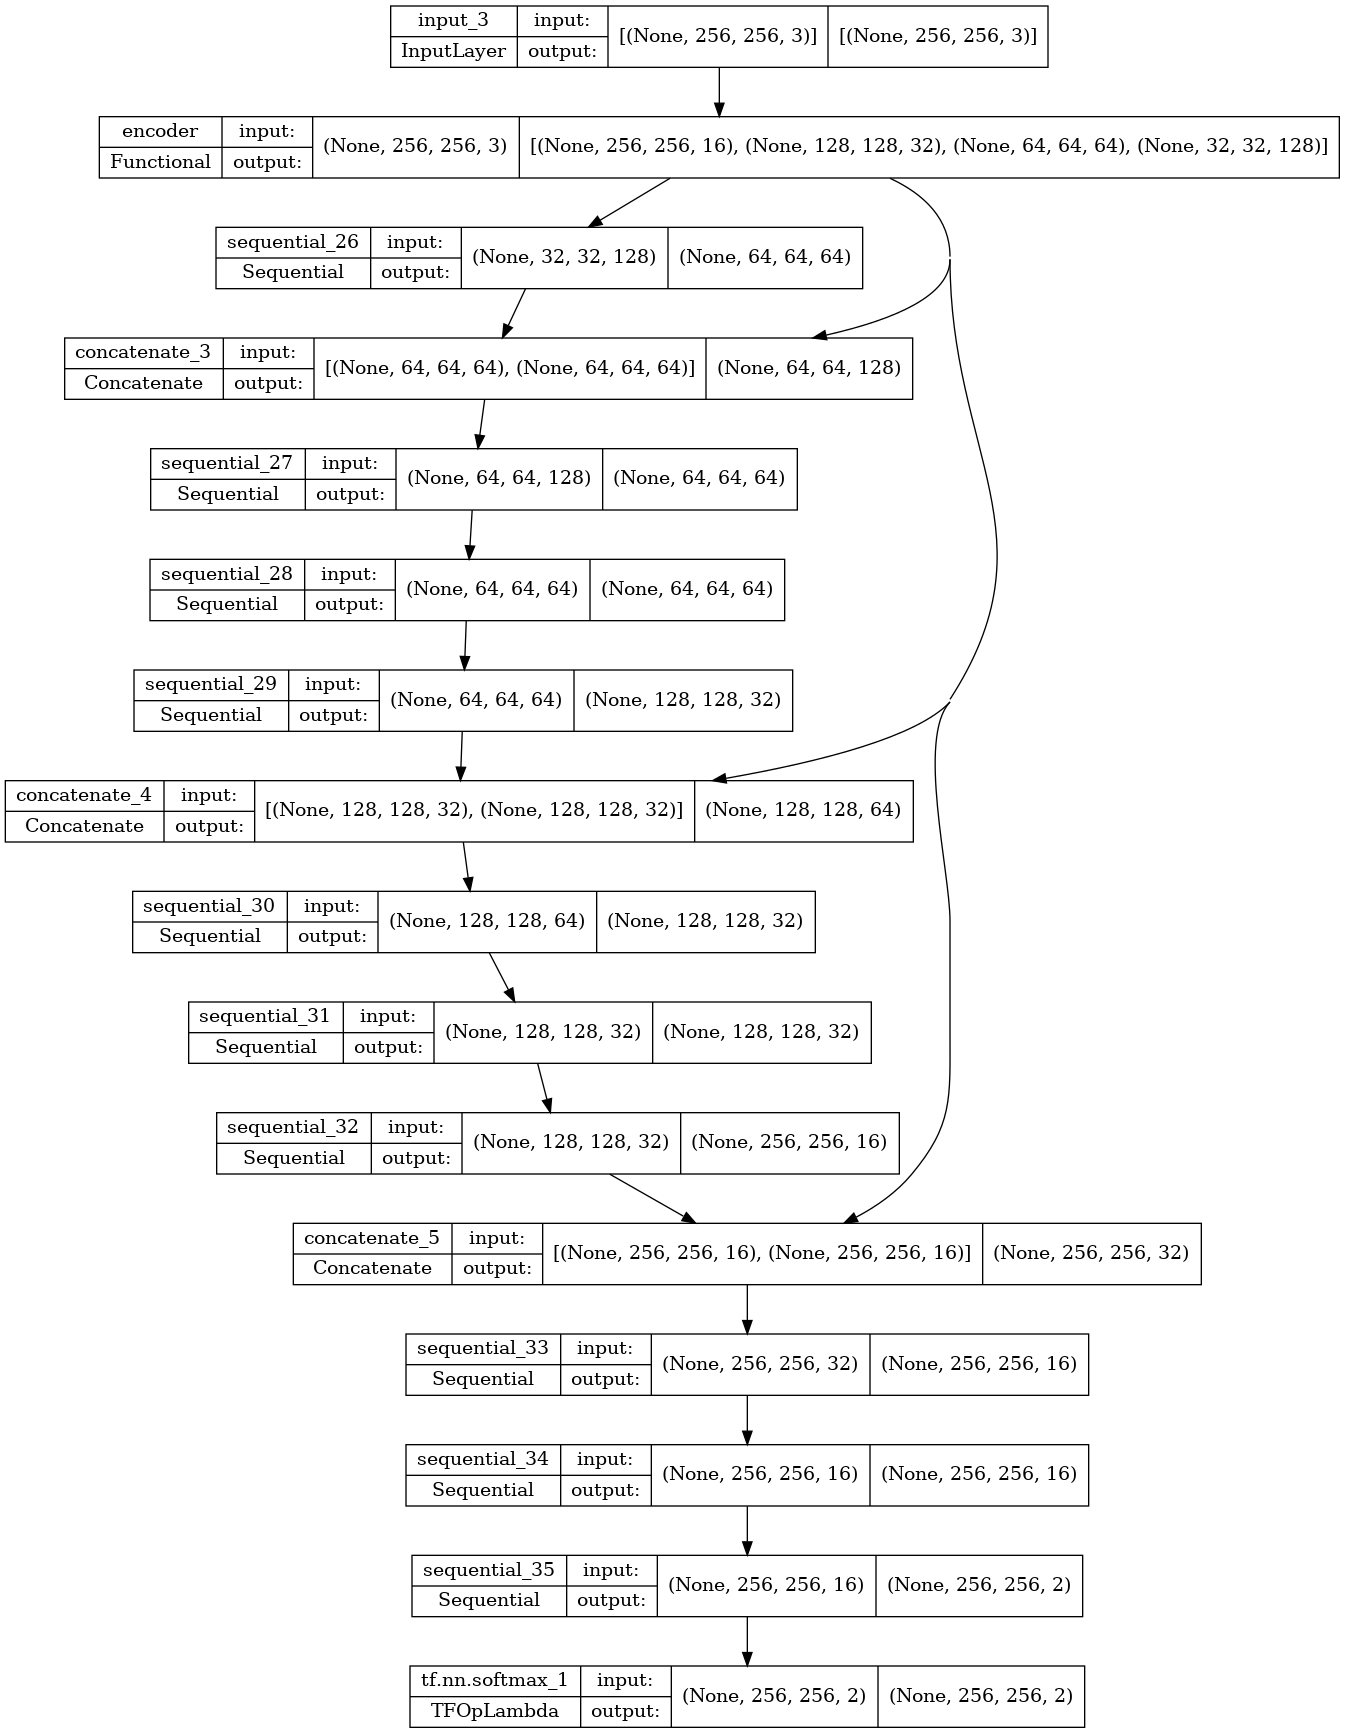

In [24]:
# Calculate the number of steps per epoch for training
STEPS_PER_EPOCH = Utils.calculate_train_length(images_list , Constants.VALIDATION_LENGTH , Constants.TEST_LENGTH) // Constants.BATCH_SIZE

# Define the optimizer using RectifiedAdam with Lookahead
optimizer = tfa.optimizers.RectifiedAdam(
    learning_rate=0.005,
    total_steps=Constants.EPOCHS * STEPS_PER_EPOCH,
    warmup_proportion=0.3,
    min_lr=0.00001,
)
optimizer = tfa.optimizers.Lookahead(optimizer)

# Define the loss function as CategoricalCrossentropy
loss = tf.keras.losses.CategoricalCrossentropy()

# Define the mean Intersection over Union metric
mIoU = IoU_nodule(num_classes=2, target_class_ids=[0, 1], sparse_y_true=False, sparse_y_pred=False, name='mean-IoU')


# Create a UNetModel instance and compile the model with the optimizer and loss function
model = UNetModel(Constants.IMG_SHAPE + (3,)).model
model.compile(optimizer=optimizer,
              loss=loss, # bce_dice_loss,
              metrics=[mIoU,Metric.dice],)

# Print the number of trainable parameters in the model
trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
print(f'Trainable params: {trainable_params}')


# Plot the model architecture using TensorFlow's plot_model() function
tf.keras.utils.plot_model(model, show_shapes=True)

### crate Model Checkpoints callback

In [14]:
# Define a ModelCheckpoint callback to save the best model during training
save_callback = keras.callbacks.ModelCheckpoint(
    filepath=Constants.CHECKPOINT_FILEPATH,
    monitor='val_mean-IoU',
    mode='max',
    save_best_only=True
)

# Load weights from a previously trained model checkpoint
model.load_weights(Constants.CHECKPOINT_FILEPATH)

2023-03-25 14:21:51.152355: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open models/wheight/model-checkpoint: FAILED_PRECONDITION: models/wheight/model-checkpoint; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


### Fit model

In [17]:
# Train the model on the training data using fit() method
model_history = model.fit(train_batches, # Training data batches
                          epochs=Constants.EPOCHS, # Number of epochs to train for
                          steps_per_epoch=STEPS_PER_EPOCH, #Number of steps per epoch
                          validation_data=validation_batches,# Validation data batches
                          callbacks=[save_callback]) # List of callbacks to use during training

3972/3972 [==============================] - ETA: 0s - loss: 0.0065 - mean-IoU: 0.7676 - dice: 0.9958

2023-03-25 22:20:21.942646: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/wheight/model-checkpoint/assets
3972/3972 [==============================] - 28600s 7s/step - loss: 0.0065 - mean-IoU: 0.7676 - dice: 0.9958 - val_loss: 0.0049 - val_mean-IoU: 0.7755 - val_dice: 0.9972


### Load weights

In [18]:
model.load_weights(Constants.CHECKPOINT_FILEPATH)

2023-03-25 22:20:27.573595: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open models/wheight/model-checkpoint: FAILED_PRECONDITION: models/wheight/model-checkpoint; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


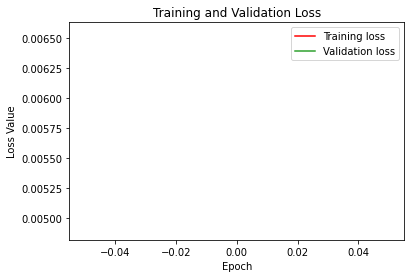

In [19]:
from matplotlib import pyplot as plt


# Get the training and validation loss from the model history
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

# Create a new figure and plot the training and validation loss
plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'C2', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

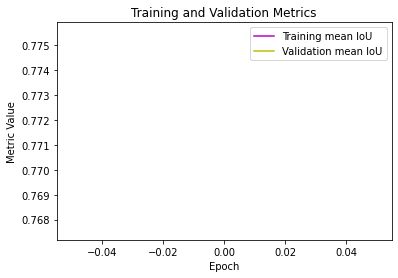

In [20]:
# Get the training and validation mean IoU from the model history
mIoU = model_history.history['mean-IoU']
val_mIoU = model_history.history['val_mean-IoU']


# Create a new figure and plot the training and validation mean IoU
plt.figure()
plt.plot(model_history.epoch, mIoU, 'm', label='Training mean IoU')
plt.plot(model_history.epoch, val_mIoU, 'y', label='Validation mean IoU')

plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

In [21]:
def predict(image):
    image = np.expand_dims(image, axis=0)
    pred_mask = model.predict(image)[0].argmax(axis=-1)
    return pred_mask

Exception ignored in: <function Executor.__del__ at 0x7fac940bdf70>
Traceback (most recent call last):
  File "/home/stepan/.local/lib/python3.8/site-packages/tensorflow/python/eager/executor.py", line 47, in __del__
    pywrap_tfe.TFE_DeleteExecutor(self._handle)
AttributeError: _handle


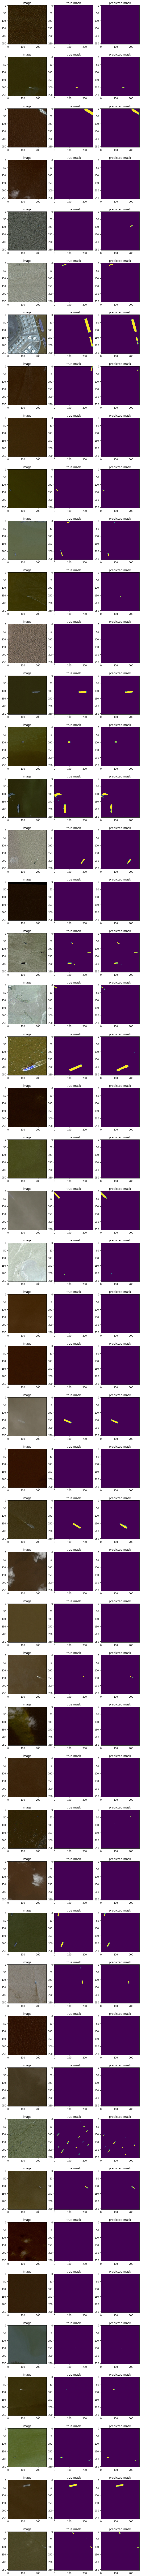

In [41]:
N = 50

f,ax = plt.subplots(N, 3, figsize=(10, 4 * N))
i = 0
for image, mask in test_dataset.take(N):
    mask = mask.numpy().argmax(axis=-1)
    ax[i, 0].imshow(image)
    ax[i, 0].set_title('image')
    ax[i, 1].imshow(mask)
    ax[i, 1].set_title('true mask')

    pred_mask = predict(image)
    ax[i, 2].imshow(pred_mask)
    ax[i, 2].set_title('predicted mask')
    i += 1

plt.show()

In [ ]:
results = model.evaluate(test_batches)
print("test loss, test mIoU:", results)

In [ ]:
mIoU = IoU(num_classes=2, target_class_ids=[0, 1], sparse_y_true=True, sparse_y_pred=True, name='mean-IoU')
IoU_results = []
for image, true_mask in test_dataset.take(Constants.TEST_LENGTH):
    true_mask = true_mask.numpy().argmax(axis=-1)
    pred_mask = predict(image)
    mIoU.update_state(true_mask, pred_mask)

    iou = IoU(num_classes=2, target_class_ids=[0, 1], sparse_y_true=True, sparse_y_pred=True, name='mean-IoU')
    iou.update_state(true_mask, pred_mask)
    IoU_results.append(iou.result())

plt.hist(IoU_results, bins=15)
print(mIoU.result())